# Machine Learning Approach

### Setup environment

In [42]:
!pip install -U scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 32.7 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2


In [30]:
!pip install datasets

### Import libs

In [45]:
# --- import utils libs ---
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns

# --- import ML libs ---
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# --- import nlp libs ---
import nltk
from nltk.tokenize import word_tokenize
from nltk.tokenize import TweetTokenizer
from nltk.tag import pos_tag
from nltk.corpus import wordnet as wn
from nltk.corpus.reader import sentiwordnet as swn
from nltk.tag import map_tag


# HuggingFace
from datasets import load_dataset

# Download corpus
nltk.download('wordnet')
nltk.download('universal_tagset')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

### Import dataset

#### Load train dataset

In [32]:
tweet_train = pd.read_csv("fin_tweets_dataset.csv")
tweet_train

,text,label
0,Keystone leak affected 10x more land than thou...,2
1,"Dybeck Happe, who joins $GE from A.P Moller-Ma...",2
2,Trump threatens China with higher tariffs if t...,0
3,Fed Report : Small-Business Sector Highly Vuln...,0
4,"Bitcoin sinks to lowest level since May, falli...",0
...,...,...
1495,Oaktree Strategic Income declares $0.155 dividend,2
1496,Highlight: Columbia Threadneedle Investments S...,2
1497,Why Fiverr Stock Rose 11% in January,1
1498,Do FDC's (NSE:FDC) Earnings Warrant Your Atten...,2


## Load test dataset

In [33]:
dataset = load_dataset("zeroshot/twitter-financial-news-sentiment")
# Convert the dictionary to a DataFrame
tweet_test = pd.DataFrame(dataset['validation'])
tweet_test

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


,text,label
0,$ALLY - Ally Financial pulls outlook https://t...,0
1,"$DELL $HPE - Dell, HPE targets trimmed on comp...",0
2,$PRTY - Moody's turns negative on Party City h...,0
3,$SAN: Deutsche Bank cuts to Hold,0
4,$SITC: Compass Point cuts to Sell,0
...,...,...
2383,Stocks making the biggest moves midday: TD Ame...,2
2384,Stocks making the biggest moves premarket: Fit...,2
2385,Stocks making the biggest moves premarket: Hom...,2
2386,Stocks making the biggest moves premarket: TD ...,2


### Preprocessing of tweets

In terms of preprocessing, we will operate as follow:
* Segment it into tokens thanks to `TweetTokenizer` thanks to `NLTK` library
* Remove urls
* Clean up characters inherent in the structure of a tweet (hashtags!)
* Correct abbreviations and language specificities in tweets using the DicoSlang dictionary (SlangLookupTable.txt file)

In [34]:
dico_slang = pd.read_csv("SlangLookupTable.txt", sep="\t", names = ["original", "new"], header=None, encoding = "latin1")
dico_slang

,original,new
0,121,one to one
1,a/s/l,"age, sex, location"
2,adn,any day now
3,afaik,as far as I know
4,afk,away from keyboard
...,...,...
85,wibni,wouldn't it be nice if
86,wtf,what the fuck
87,wtg,way to go
88,wtgp,want to go private


In [35]:
def preprocessing_tweet(text_tweet, dico_slang):

    # tokenization du tweet avec TweetTokenizer (garde les émoticones, retire les @[username])
    tk = nltk.TweetTokenizer()
    text_tweet_tokenized = tk.tokenize(text_tweet)
    text_tweet_cleaned = list()

    original_list = dico_slang["original"].to_list()
    new_list = dico_slang["new"].to_list()

    # remove inherent tweet special characters like #hashtag
    for elm in text_tweet_tokenized:
        if elm.startswith('http'):
            pass

        elif elm.startswith('@'):
            pass

        elif elm.startswith("#"):
            elm = elm.split("#")[1]
            text_tweet_cleaned.append(elm)

        else:
            text_tweet_cleaned.append(elm)

        # Correction des abréviations et des spécificités langagières des tweets
        for i in range (len(original_list)):
            if original_list[i] == elm:
                new = new_list[i]
                list_word = word_tokenize(new)
                for word in list_word:
                    text_tweet_cleaned.append(word)

            if original_list[i] == elm:
                text_tweet_cleaned.remove(elm)

        # Remove empty string
        text_tweet_cleaned = [e for e in text_tweet_cleaned if e]

    return text_tweet_cleaned

#### Preprocessing of train tweets

In [36]:
l_token = list()
for i in range(tweet_train.shape[0]):
    l_token.append(preprocessing_tweet(tweet_train.iloc[i,0], dico_slang))

tweet_train = tweet_train.join(pd.DataFrame({"tweet_cleaned":l_token}))
tweet_train

,text,label,tweet_cleaned
0,Keystone leak affected 10x more land than thou...,2,"[Keystone, leak, affected, 10x, more, land, th..."
1,"Dybeck Happe, who joins $GE from A.P Moller-Ma...",2,"[Dybeck, Happe, ,, who, joins, $, GE, from, A,..."
2,Trump threatens China with higher tariffs if t...,0,"[Trump, threatens, China, with, higher, tariff..."
3,Fed Report : Small-Business Sector Highly Vuln...,0,"[Fed, Report, :, Small-Business, Sector, Highl..."
4,"Bitcoin sinks to lowest level since May, falli...",0,"[Bitcoin, sinks, to, lowest, level, since, May..."
...,...,...,...
1495,Oaktree Strategic Income declares $0.155 dividend,2,"[Oaktree, Strategic, Income, declares, $, 0.15..."
1496,Highlight: Columbia Threadneedle Investments S...,2,"[Highlight, :, Columbia, Threadneedle, Investm..."
1497,Why Fiverr Stock Rose 11% in January,1,"[Why, Fiverr, Stock, Rose, 11, %, in, January]"
1498,Do FDC's (NSE:FDC) Earnings Warrant Your Atten...,2,"[Do, FDC's, (, NSE, :, FDC, ), Earnings, Warra..."


On va maintenant chercher à pré-traiter nos données de manière à simplifier la tâche du modèle. Notez toujours que celà ne sera probablement utile que si l'on a trop peu de données à disposition !

Stemming:
Permet de revenir à la racine d'un mot: on peut ainsi grouper différents mots autour de la même racine, ce qui facilite la généralisation. On peut utiliser l'outil `SnowballStemmer`.

In [37]:
from nltk import SnowballStemmer
stemmer = SnowballStemmer("english")

def preprocess_stem(list_token):

    text_ = ' '.join([stemmer.stem(word) for word in list_token])

    return text_

In [38]:
l_token = list()
for i in range(tweet_train.shape[0]):
    l_token.append(preprocess_stem(tweet_train.iloc[i,2]))

tweet_train = tweet_train.join(pd.DataFrame({"tweet_stemmed":l_token}))
tweet_train

,text,label,tweet_cleaned,tweet_stemmed
0,Keystone leak affected 10x more land than thou...,2,"[Keystone, leak, affected, 10x, more, land, th...",keyston leak affect 10x more land than thought...
1,"Dybeck Happe, who joins $GE from A.P Moller-Ma...",2,"[Dybeck, Happe, ,, who, joins, $, GE, from, A,...","dybeck happ , who join $ ge from a . p moller-..."
2,Trump threatens China with higher tariffs if t...,0,"[Trump, threatens, China, with, higher, tariff...",trump threaten china with higher tariff if tra...
3,Fed Report : Small-Business Sector Highly Vuln...,0,"[Fed, Report, :, Small-Business, Sector, Highl...",fed report : small-busi sector high vulner to ...
4,"Bitcoin sinks to lowest level since May, falli...",0,"[Bitcoin, sinks, to, lowest, level, since, May...","bitcoin sink to lowest level sinc may , fall $..."
...,...,...,...,...
1495,Oaktree Strategic Income declares $0.155 dividend,2,"[Oaktree, Strategic, Income, declares, $, 0.15...",oaktre strateg incom declar $ 0.155 dividend
1496,Highlight: Columbia Threadneedle Investments S...,2,"[Highlight, :, Columbia, Threadneedle, Investm...",highlight : columbia threadneedl invest senior...
1497,Why Fiverr Stock Rose 11% in January,1,"[Why, Fiverr, Stock, Rose, 11, %, in, January]",whi fiverr stock rose 11 % in januari
1498,Do FDC's (NSE:FDC) Earnings Warrant Your Atten...,2,"[Do, FDC's, (, NSE, :, FDC, ), Earnings, Warra...",do fdc ( nse : fdc ) earn warrant your attent ?


We apply the following pipeline `{CountVectorizer, TF-IDF, MultinomialNB}`

#### CountVectorizer

`CountVectorizer` is used to convert a collection of text documents into a matrix of token counts. In simpler terms, it converts a text document into a vector where each element of the vector corresponds to the count of a particular word in the document. This process is also known as "bag-of-words" representation.

Once tokenized, CountVectorizer builds a vocabulary from all the words in the documents. It considers each unique word as a feature. For each document, the vectorizer counts the occurrence of each word (from the vocabulary) and places that count in the corresponding position of the vector. If a word doesn't appear in a particular document, its count will be zero.

CountVectorizer is used in various NLP tasks like text classification, clustering, sentiment analysis, and more. By converting text data into a numerical format (vector representation), it becomes easier to apply machine learning algorithms that require numerical input.

To sum up CountVectorizer is a powerful tool for converting text data into a format that can be fed into machine learning models. It facilitates the transformation of textual information into a structured numerical representation suitable for machine learning tasks.

#### Tf-idf:

This is the product of the frequency of the term (TF) and its inverse frequency in the documents (IDF).
This method is usually used to extract the importance of a term $i$ in a document $j$ relative to the rest of the corpus, from a matrix of occurrences $words \times documents$. Thus, for a matrix $\mathbf{T}$ of $|V|$ terms and $D$ documents:
$$\text{TF}(T, w, d) = \frac{T_{w,d}}{\sum_{w'=1}^{|V|} T_{w',d}} $$

$$\text{IDF}(T, w) = \log\left(\frac{D}{|\{d : T_{w,d} > 0\}|}\right)$$

$$\text{TF-IDF}(T, w, d) = \text{TF}(X, w, d) \cdot \text{IDF}(T, w)$$

It can be adapted to our case by considering that the context of the second word is the document. However, TF-IDF is generally better suited to sparse matrices, since this measure will penalise terms that appear in a large proportion of documents.

#### MultinomialNB:

Then We will use scikit-learn's `MultinomialNB`, an implementation of the naive Bayesian model. Here, the naive hypothesis is that the different variables (words) in a review are independent of each other.

In [39]:
tweet_test

,text,label
0,$ALLY - Ally Financial pulls outlook https://t...,0
1,"$DELL $HPE - Dell, HPE targets trimmed on comp...",0
2,$PRTY - Moody's turns negative on Party City h...,0
3,$SAN: Deutsche Bank cuts to Hold,0
4,$SITC: Compass Point cuts to Sell,0
...,...,...
2383,Stocks making the biggest moves midday: TD Ame...,2
2384,Stocks making the biggest moves premarket: Fit...,2
2385,Stocks making the biggest moves premarket: Hom...,2
2386,Stocks making the biggest moves premarket: TD ...,2


In [48]:
tweet_test_label

0       0
1       0
2       0
3       0
4       0
       ..
2383    2
2384    2
2385    2
2386    2
2387    2
Name: label, Length: 2388, dtype: int64

In [40]:
tweet_train_stemmed = tweet_train["tweet_stemmed"]
tweet_train_label = tweet_train["label"]

tweet_test_content = tweet_test["text"]
tweet_test_label = tweet_test["label"]

In [53]:
pipe = Pipeline([('vec_count', CountVectorizer(max_features= 10000, analyzer='word', max_df=0.2, ngram_range=(1,3))),
                 ('tfidf', TfidfTransformer()),
                 ('clf', MultinomialNB())
                 ])

pipe.fit(tweet_train_stemmed, tweet_train_label)

print("features names")
feat_names = pipe['vec_count'].get_feature_names_out()

print("\n-------------------------\n")

print("Vocabulary")
vocab = pipe['vec_count'].vocabulary_
print(vocab)

print("\n-------------------------\n")

print("CountVectorizer")
vec_count = pipe['vec_count'].transform(tweet_train_stemmed).toarray()
print(vec_count)

print("\n-------------------------\n")

print("TF-IDF")
tf_idf = pipe['tfidf'].idf_
print(tf_idf)
print(len(tf_idf))

print("\n-------------------------\n")

# Make predictions
predictions = pipe.predict(tweet_test_content)

print("Predictions")
print(predictions)

# Show the results in a readable format
print("\n\n---- Classification report ----")

report_classification = classification_report(tweet_test_label, predictions)

print(report_classification)

features names

-------------------------

Vocabulary
{'affect': 203, 'more': 3009, 'land': 1813, 'than': 8025, 'thought': 8525, 'regul': 7496, 'say': 7627, 'more land': 3049, 'thought regul': 8526, 'more land than': 3050, 'thought regul say': 8527, 'who': 9312, 'join': 1771, 'from': 1339, 'moller': 2923, 'maersk': 2062, 'the': 8033, 'world': 9615, 'biggest': 533, 'contain': 828, 'ship': 7724, 'group': 1449, 'will': 9348, 'take': 7956, 'over': 5367, 'who join': 9313, 'moller maersk': 2924, 'maersk the': 2063, 'the world': 8281, 'world biggest': 9620, 'group will': 1454, 'will take': 9403, 'over fo': 5396, 'who join ge': 9314, 'moller maersk the': 2925, 'maersk the world': 2064, 'the world biggest': 8283, 'world biggest contain': 9621, 'will take over': 9404, 'trump': 8989, 'threaten': 8540, 'china': 743, 'with': 9460, 'higher': 1515, 'tariff': 7974, 'if': 1579, 'trade': 8956, 'deal': 917, 'not': 3835, 'made': 2055, 'threaten china': 8541, 'with higher': 9498, 'trade deal': 8958, 'deal 

### Plot confusion matrix

In [51]:
# Create a dataframe using pandas
df_conf_matrix = pd.DataFrame({'y_true': tweet_test_label.tolist(), 'y_pred': predictions})

# Replace values in the dataframe
mapping = {0: 'bearish', 1: 'bullish', 2: 'neutral'}
df_conf_matrix['y_true'] = df_conf_matrix['y_true'].replace(mapping)
df_conf_matrix['y_pred'] = df_conf_matrix['y_pred'].replace(mapping)

# Display the updated dataframe
df_conf_matrix

,y_true,y_pred
0,bearish,neutral
1,bearish,bullish
2,bearish,bullish
3,bearish,neutral
4,bearish,bearish
...,...,...
2383,neutral,neutral
2384,neutral,bearish
2385,neutral,bearish
2386,neutral,neutral


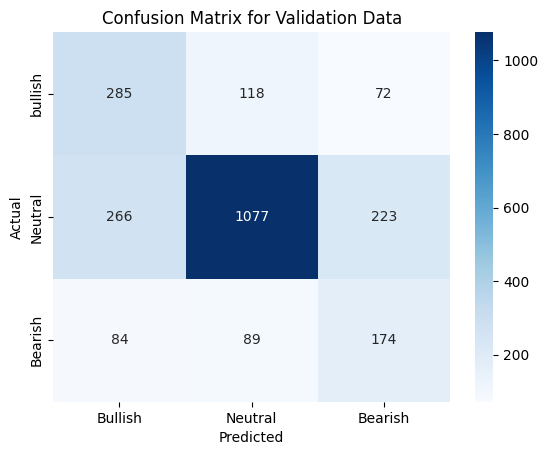

In [52]:
conf_matrix = confusion_matrix(df_conf_matrix["y_true"], df_conf_matrix["y_pred"], labels=['bullish', 'neutral', 'bearish'])

sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Bullish', 'Neutral', 'Bearish'], yticklabels=['bullish', 'Neutral', 'Bearish'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix for Validation Data')
plt.show()